In [77]:
from datetime import datetime, timedelta
from dateutil.relativedelta import *
import pandas as pd
import matplotlib.pyplot as plt
import folium
import numpy as np

# Addendum: working with BayWheels data
It's sort of tangential to the original post, but I actually had a great time wrangling BayWheels data. Including an overview of what I did below for (the few) data/biking enthusiasts out there who might benefit. Definitely not a data engineer, so if the peanut gallery has any comments I'd [love to hear 'em](mailto:adithyaparams@berkeley.edu).

## Sourcing personal + public ride history
Inspiration for the proj struck when I stumbled onto a public [S3 bucket](https://s3.amazonaws.com/baywheels-data/index.html) where Lyft kindly hosts data of all BayWheels rides, binned into csvs for each month. Downloaded the file for May 2023, in hopes of isolating just the rides from my ride history:

In [8]:
pd.read_csv('data/202305-baywheels-tripdata.csv').drop(['start_station_id', 'end_station_id'], axis=1)


,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual
0,7800BB2AD9402F88,classic_bike,2023-05-30 17:50:01,2023-05-30 18:28:53,San Pablo Park,San Pablo Park,37.855783,-122.283127,37.855783,-122.283127,casual
1,80DCF4F3F0523472,classic_bike,2023-05-03 13:09:04,2023-05-03 13:17:25,San Pablo Park,Oregon St at Adeline St,37.855783,-122.283127,37.857567,-122.267558,member
2,761FC46C050F93E5,electric_bike,2023-05-17 17:40:44,2023-05-17 18:38:19,Jones St at Post St,1st St at Folsom St,37.787510,-122.413198,37.787290,-122.394380,member
3,EC2D3954EEC4BBDB,classic_bike,2023-05-02 08:47:43,2023-05-02 08:56:54,Jones St at Post St,Brannan St at 4th St,37.787327,-122.413278,37.777934,-122.396973,member
4,27A9491004882A45,classic_bike,2023-05-07 16:41:47,2023-05-07 16:52:24,San Pablo Park,Market St at 45th St,37.855783,-122.283127,37.834174,-122.272968,member
...,...,...,...,...,...,...,...,...,...,...,...
218016,8AE26B32B1FB61AB,electric_bike,2023-05-27 19:12:04,2023-05-27 19:29:18,San Francisco Ferry Building (Harry Bridges Pl...,Pier 1/2 at The Embarcadero,37.795448,-122.394333,37.796389,-122.394586,casual
218017,13DC635F340C2CCC,electric_bike,2023-05-06 00:53:30,2023-05-06 02:23:21,San Francisco Ferry Building (Harry Bridges Pl...,Embarcadero BART Station (Beale St at Market St),37.795448,-122.394353,37.792251,-122.397086,casual
218018,181992B61F004033,electric_bike,2023-05-06 00:53:53,2023-05-06 02:22:57,San Francisco Ferry Building (Harry Bridges Pl...,Embarcadero BART Station (Beale St at Market St),37.795439,-122.394363,37.792251,-122.397086,casual
218019,34A53D6093AB0BC2,electric_bike,2023-05-24 08:54:21,2023-05-24 09:16:54,MacArthur Ave at Fernandez St,Pier 1/2 at The Embarcadero,37.796587,-122.455722,37.796389,-122.394586,member


But it looks like Lyft doesn't expose a user-associated key with each ride so that's a dead end. Did manage to find https://account.baywheels.com/ride-history though, where they list out every ride I've taken and some of the info (start/end stations, time, bike ID) associated with each one.

![](assets/site-ride-history.png)

After some time tooling around with a Selenium [script](https://github.com/adithyaparams/baywheels-viz/blob/main/scrape.py), ended up with a nicely formatted [dataframe](https://github.com/adithyaparams/baywheels-viz/blob/main/past_rides.csv):

In [9]:
pd.read_csv('past_rides.csv')

,Unnamed: 0,date,bike_id,price,start_time,end_time,start_loc,end_loc
0,0,"May 19, 2023",79338,$3.81,2:05 AM,2:13 AM,Haste St at College Ave,Berkeley Civic Center
1,1,"May 18, 2023",830-0543,$3.81,1:16 AM,1:19 AM,Channing Way at Shattuck Ave,Berkeley Civic Center
2,2,"May 13, 2023",406-5314,$0.00,2:04 AM,2:07 AM,Channing Way at Shattuck Ave,Berkeley Civic Center
3,3,"April 29, 2023",584-993,$8.55,5:14 PM,5:44 PM,Market St at Steuart St,North Point St at Polk St
4,4,"April 24, 2023",875-0044,$3.81,2:48 AM,2:51 AM,Channing Way at Shattuck Ave,Berkeley Civic Center
...,...,...,...,...,...,...,...,...
641,641,"July 24, 2021",12213,$3.28,9:07 AM,9:34 AM,Berkeley Civic Center,Ninth St at Heinz Ave
642,642,"July 18, 2021",15141,$3.28,2:59 PM,3:19 PM,Ninth St at Heinz Ave,MLK Jr Way at University Ave
643,643,"July 16, 2021",12421,$3.28,3:52 PM,4:16 PM,55th St at Telegraph Ave,MLK Jr Way at University Ave
644,644,"July 16, 2021",67957,$3.28,2:37 PM,3:03 PM,MLK Jr Way at University Ave,55th St at Telegraph Ave


## Merging datasets

With personal ride history parsed, I wanted to run a left join of my history with the public dataset to get access to other useful ride attributes (ride id, station coordinates, etc.). There's no foreign key shared by both dataframes, which makes this a little more difficult. First tried to do a sort of 'fuzzy' left join with nearest start time (fuzzy bc start time in the public dataset is accurate to the second, while my ride history rounds off at the minute). But BayWheels actually often has 3-4 many rides per minute, so the rides closest to my (rounded) ride time were often actually in SF; not the ones I was looking for.

Eventually got the merge to work with a 'hacky' foreign key, a concatenated string with rounded start time + rounded end time + start station + end station. Heavy lifting is done with a [separate script](https://github.com/adithyaparams/baywheels-viz/blob/main/merge.py), but it does a pretty solid job.

In [32]:
merged = pd.read_csv('merged.csv')
nice_cols = ['ride_id', 'bike_id', 'price', 'member_casual', 'rideable_type',
             'started_at', 'ended_at', 'start_station_name', 'end_station_name',
             'start_lat', 'start_lng', 'end_lat', 'end_lng', 'member_casual',
             'start_station_id', 'end_station_id'] # create an array of columns for display purposes 
merged[nice_cols]

,ride_id,bike_id,price,member_casual,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual,start_station_id,end_station_id
0,CEFEF8105A3E0DC2,77378,$3.28,casual,classic_bike,2021-05-14 11:50:53,2021-05-14 12:20:33,55th St at Telegraph Ave,MLK Jr Way at University Ave,37.840186,-122.261822,37.871719,-122.273068,casual,OK-C3,BK-C6
1,40DCA619CDD9D1DA,13441,$3.28,casual,classic_bike,2021-07-31 13:26:53,2021-07-31 13:56:01,Berkeley Civic Center,MLK Jr Way at University Ave,37.869060,-122.270556,37.871719,-122.273068,casual,BK-D7-2,BK-C6
2,3DC43ED880F49D3E,12213,$3.28,casual,classic_bike,2021-07-24 13:03:25,2021-07-24 13:23:25,Ninth St at Heinz Ave,MLK Jr Way at University Ave,37.853907,-122.289698,37.871719,-122.273068,casual,BK-H3,BK-C6
3,DE3D3398F4955770,12213,$3.28,casual,classic_bike,2021-07-24 09:07:55,2021-07-24 09:35:27,Berkeley Civic Center,Ninth St at Heinz Ave,37.869060,-122.270556,37.853907,-122.289698,casual,BK-D7-2,BK-H3
4,93EB1910E97D6C77,15141,$3.28,casual,classic_bike,2021-07-18 14:59:21,2021-07-18 15:19:25,Ninth St at Heinz Ave,MLK Jr Way at University Ave,37.853907,-122.289698,37.871719,-122.273068,casual,BK-H3,BK-C6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658,3CD2BC95A2BA4243,847-2961,$3.81,casual,classic_bike,2023-04-08 20:27:00,2023-04-08 20:29:51,Berkeley Civic Center,Channing Way at Shattuck Ave,37.869060,-122.270556,37.865847,-122.267443,casual,BK-D7-2,BK-E7
659,94E7B52669336021,847-2961,$3.81,casual,classic_bike,2023-04-08 00:50:31,2023-04-08 01:01:17,Bancroft Way at College Ave,Berkeley Civic Center,37.869360,-122.254337,37.869060,-122.270556,casual,BK-D10,BK-D7-2
660,E9A6997C16D6859C,79338,$3.81,casual,classic_bike,2023-05-19 02:05:45,2023-05-19 02:13:21,Haste St at College Ave,Berkeley Civic Center,37.866418,-122.253799,37.869060,-122.270556,casual,BK-E10,BK-D7-2
661,0F20DFA04DF5BDCA,830-0543,$3.81,casual,classic_bike,2023-05-18 01:16:13,2023-05-18 01:18:33,Channing Way at Shattuck Ave,Berkeley Civic Center,37.865847,-122.267443,37.869060,-122.270556,casual,BK-E7,BK-D7-2


### Final sanitization
There's some extra cleaning that needs to be done before the dataset's totally ready. First, checking for failed merges.

In [33]:
merged[merged['ride_id'].isna()]

,Unnamed: 0.1,Unnamed: 0,date,bike_id,price,start_time,end_time,start_loc,end_loc,start_datetime_x,...,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,start_datetime_y,end_datetime_y
193,55,508,"November 3, 2021",17225,$0.00,10:47 AM,10:59 AM,Ninth St at Heinz Ave,Berkeley Civic Center,2021-11-03 10:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421,6,223,"June 15, 2022",558-9585,$0.00,12:43 PM,12:59 PM,Ninth St at Heinz Ave,MLK Jr Way at University Ave,2022-06-15 12:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
490,22,164,"September 19, 2022",838-8605,$0.00,12:57 AM,1:00 AM,Channing Way at Shattuck Ave,Berkeley Civic Center,2022-09-19 00:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Some extra searching through the public datasets shows that these rides are likely in the middle of some downtime; there's a 10-20 minute block when no rides are recorded. Regardless, being able to find 643/646 rides in the public dataset is great! The merged dataframe has 663 rows though (660 without the failed merges) which means there are likely some dupes in the dataset. Let's see what they look like.

In [34]:
without_na = merged[~merged['ride_id'].isna()].sort_values(['hacky_key', 'member_casual'])
without_na[without_na.duplicated(subset=['hacky_key'],keep=False)][nice_cols]

,ride_id,bike_id,price,member_casual,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual,start_station_id,end_station_id
133,771774739E1D3301,16571,$0.00,casual,classic_bike,2021-10-01 16:27:42,2021-10-01 16:47:06,Ninth St at Heinz Ave,Addison St at Fourth St,37.853907,-122.289698,37.866249,-122.299371,casual,BK-H3,BK-D1
134,11BB13B59607E5B3,16571,$0.00,casual,classic_bike,2021-10-01 16:26:16,2021-10-01 16:49:59,Ninth St at Heinz Ave,Addison St at Fourth St,37.853907,-122.289698,37.866249,-122.299371,casual,BK-H3,BK-D1
132,A029C6215524D7F7,16571,$0.00,member,classic_bike,2021-10-01 16:29:09,2021-10-01 16:46:42,Ninth St at Heinz Ave,Addison St at Fourth St,37.853907,-122.289698,37.866249,-122.299371,member,BK-H3,BK-D1
336,054922F8D7E26158,16605,$0.00,casual,classic_bike,2022-04-26 22:24:36,2022-04-26 22:28:02,Berkeley Civic Center,Berkeley Civic Center,37.869060,-122.270556,37.869060,-122.270556,casual,BK-D7-2,BK-D7-2
335,9873F8EFB6B01E0A,16605,$0.00,member,classic_bike,2022-04-26 22:22:55,2022-04-26 22:28:42,Berkeley Civic Center,Berkeley Civic Center,37.869060,-122.270556,37.869060,-122.270556,member,BK-D7-2,BK-D7-2
381,56F5CFDF45833233,68458,$0.00,casual,classic_bike,2022-05-29 13:57:25,2022-05-29 14:13:27,San Francisco Ferry Building (Harry Bridges Pl...,North Point St at Powell St,37.795392,-122.394203,37.806929,-122.411536,casual,SF-E29-1,SF-A25
382,3503DF6F16D323CA,68458,$0.00,casual,classic_bike,2022-05-29 13:57:11,2022-05-29 14:13:15,San Francisco Ferry Building (Harry Bridges Pl...,North Point St at Powell St,37.795392,-122.394203,37.806929,-122.411536,casual,SF-E29-1,SF-A25
383,51B3F034530FD48D,68458,$0.00,member,classic_bike,2022-05-29 13:54:36,2022-05-29 14:12:52,San Francisco Ferry Building (Harry Bridges Pl...,North Point St at Powell St,37.795392,-122.394203,37.806929,-122.411536,member,SF-E29-1,SF-A25
506,DFAEF10A5FEF043A,248-9169,$0.00,member,classic_bike,2022-09-02 16:51:51,2022-09-02 16:58:48,Bancroft Way at Telegraph Ave,Berkeley Civic Center,37.868911,-122.258786,37.869060,-122.270556,member,BK-E9-1,BK-D7-2
507,FAFA3CE543E743CE,248-9169,$0.00,member,classic_bike,2022-09-02 16:12:23,2022-09-02 16:26:26,Bancroft Way at Telegraph Ave,Berkeley Civic Center,37.868911,-122.258786,37.869060,-122.270556,member,BK-E9-1,BK-D7-2


These dupes are actually not a coincidence; all rides start and end within 30 seconds of each other at the same stations. This is likely bc these pairs (and triplets) of duplicates actually come from rides I've taken with friends, convincing them to tour Berkeley/SF with me by bike! 

Removing the dupes gets us down to 643 rides.

In [35]:
personal_rides = without_na[~without_na.duplicated(subset=['hacky_key'],keep='last')][nice_cols]
personal_rides.to_csv('my_rides.csv', index=False)

That's pretty much it; with the data merged and sanitized, there's plenty of fun stuff to learn from the data.

In [36]:
minutes_biked = sum(pd.to_datetime(personal_rides['ended_at']) - pd.to_datetime(personal_rides['started_at']), timedelta()).total_seconds() / 60
years_used = (max(pd.to_datetime(personal_rides['ended_at'])) - min(pd.to_datetime(personal_rides['started_at']))).total_seconds() / 3.154e+7

'''{num_rides} rides biked for a total of {num_minutes} minutes, or {num_hours} hours, of riding from {years_used} years of using BayWheels!'''.format(
    num_rides=len(personal_rides), num_minutes=round(minutes_biked, 2), num_hours=round(minutes_biked/60, 2), years_used=round(years_used, 2))

'643 rides biked for a total of 6943.17 minutes, or 115.72 hours, of riding from 2.01 years of using BayWheels!'

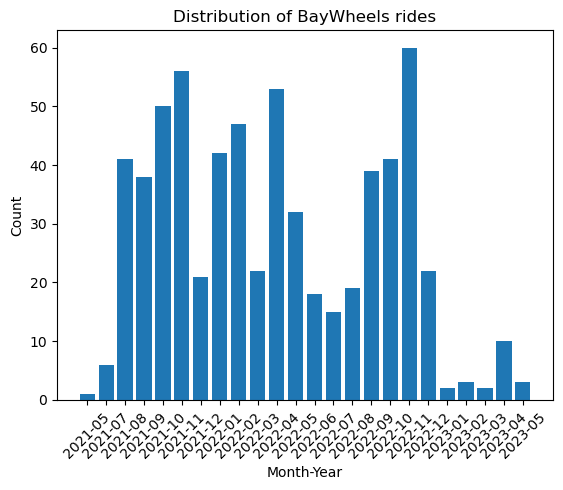

In [37]:
hist_data = pd.to_datetime(personal_rides['started_at']).dt.to_period('M').value_counts()

# Sort the data by index (MonthYear)
hist_data = hist_data.sort_index()

# Plot the histogram
plt.bar(hist_data.index.astype(str), hist_data.values)

# Set the x-axis label and title
plt.xlabel('Month-Year')
plt.ylabel('Count')
plt.title('Distribution of BayWheels rides')

# Rotate x-axis labels for readability (optional)
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [75]:
lat_min = 37.86300
lat_max = 37.87800
long_min = -122.2750
long_max = -122.2475

berkeley_latitude = (lat_min + lat_max) / 2
berkeley_longitude = (long_min + long_max) / 2

map_berkeley = folium.Map(location=[berkeley_latitude, berkeley_longitude], zoom_start=15, tiles='cartodbpositron')

In [74]:
start_stations = personal_rides.groupby(['start_station_name', 'start_station_id', 'start_lat', 'start_lng'])['start_station_id'].count().reset_index(name="count")
end_stations = personal_rides.groupby(['end_station_name', 'end_station_id', 'end_lat', 'end_lng'])['end_station_id'].count().reset_index(name="count")

my_stations = pd.concat((start_stations.rename(columns={"start_station_id": "id", "start_lng": "lng", "start_lat": "lat"}), 
                         end_stations.rename(columns={"end_station_id": "id", "end_lng": "lng", "end_lat": "lat"}))
                       ).drop_duplicates()

for lat, lng in zip(list(my_stations['lat']), list(my_stations['lng'])):
        folium.CircleMarker(location=[lat, lng], radius=5, color='pink', fill=True, fill_color='pink').add_to(map_berkeley)
        
map_berkeley

In [133]:
start_stop = folium.Map(location=[berkeley_latitude, berkeley_longitude], zoom_start=15, tiles='cartodbpositron')

end_with_start = end_stations.merge(start_stations, how='left', left_on='end_station_id', right_on='start_station_id')
end_with_start[['count_x', 'count_y']] = end_with_start[['count_x', 'count_y']].fillna(0)
end_with_start['count_x'] = np.log(end_with_start['count_x'])*3 + .00001
end_with_start['count_y'] = np.log(end_with_start['count_y'] + .00001)*3 + .00001
end_with_start['count'] = end_with_start['count_x'] + end_with_start['count_y']
end_with_start = end_with_start.drop(['count_x', 'count_y', 'start_station_name', 'start_station_id', 'start_lat', 'start_lng'], axis=1)
end_with_start = end_with_start.rename(columns={'end_station_name':'station_name', 
                                      'end_station_id':'station_id', 
                                      'end_lat':'lat', 
                                      'end_lng':'lng'})
# end_with_start['count'] = np.log(end_with_start['count'])*2 + .00001

for lat, lng, radius in zip(list(end_with_start['lat']), list(end_with_start['lng']), list(end_with_start['count'])):
        folium.CircleMarker(location=[lat, lng], radius=radius, color='red', fill=True, fill_color='red').add_to(start_stop)

In [134]:
start_radius = start_stations.copy()
start_radius['count'] = np.log(start_radius['count'])*3 + .00001

for lat, lng, radius in zip(list(start_radius['start_lat']), list(start_radius['start_lng']), list(start_radius['count'])):
        folium.CircleMarker(location=[lat, lng], radius=radius, color='green', fill=True, fill_color='green').add_to(start_stop)

In [135]:
start_stop

In [108]:
end_stations

,end_station_name,end_station_id,end_lat,end_lng,count
0,10th St at University Ave,BK-D2,37.869060,-122.293400,2
1,55th St at Telegraph Ave,OK-C3,37.840186,-122.261822,1
2,Addison St at Fourth St,BK-D1,37.866249,-122.299371,1
3,Bancroft Way at College Ave,BK-D10,37.869360,-122.254337,1
4,Berkeley Civic Center,BK-D7-2,37.869060,-122.270556,272
5,California St at University Ave,BK-D5,37.870555,-122.279720,1
6,Channing Way at San Pablo Ave,BK-E3,37.862827,-122.290231,1
7,Channing Way at Shattuck Ave,BK-E7,37.865847,-122.267443,36
8,Cyril Magnin St at Ellis St,SF-G26,37.785876,-122.408923,1
9,Downtown Berkeley BART,BK-D7-1,37.870139,-122.268422,2
